In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib as mpl
import numpy.ma as ma
from scipy import interpolate

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def get_salt_daily(time_s):
    time_f = time_s+24
    vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, 
                                                                          None, time_s, time_f, None)
    vosaline_daily = np.mean(vosaline, axis=0)
    return vosaline_daily, tmask, deptht

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def get_varb_surf(vosaline_array, salt, varb):
    
    if len(vosaline_array.shape)==1:
        f = interpolate.interp1d(vosaline_array, varb)
        ynew = f(salt)
        varb_array = ynew
        
    else:
        varb_array = np.full([vosaline_array.shape[-2], vosaline_array.shape[-1]], np.nan)
        for i in range(vosaline_array.shape[-1]):
            for j in range(vosaline_array.shape[-2]):
                vosaline_column = vosaline_array[:, j, i]

                try:
                    f = interpolate.interp1d(vosaline_column, varb)
                    ynew = f(salt)
                    varb_array[j, i] = ynew
                except ValueError:
                    varb_array[j, i] = np.nan  
                
    return varb_array

In [3]:
def plot(vosaline_daily_all, salt_all, water_mass, ttls, vmaxs, vmins, bathy):

    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, gridspec_kw={'width_ratios': [5, 5, 5, 0.1]}, 
                             figsize=(20, 13))

    for col in range(3):
        vosaline_daily = vosaline_daily_all[col]
        for row in range(2):
            ax=axes[row, col]
            vmin = vmins[row]
            vmax = vmaxs[row]
            salt = salt_all[row]
            cmap = cmo.cm.curl_r
            cmap.set_bad('silver')

            varb = deptht
            
            # Initial depth
            depth_initial = get_varb_surf(vosaline_ref_profile, salt, varb)
            norm = upwelling_functions.MidpointNormalize(midpoint=depth_initial)
            
            # Particular day
            depth_daily = get_varb_surf(vosaline_daily, salt, varb)
            print(col, row, depth_initial, np.nanmin(depth_daily), np.nanmax(depth_daily))
            
            xs = np.arange(depth_daily.shape[1])
            ys = np.arange(depth_daily.shape[0])
            p = ax.pcolormesh(xs, ys, depth_daily, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
            
            ax.tick_params(axis='both', which='both', length=0)
            ax.set_aspect(aspect='equal')
            ax.set_xlim([0, xs[-1]])
            ax.set_ylim([0, ys[-1]])

            if row==0: ax.set_title(ttls[col], fontsize=25, y=1.08)
            else: pass

            if row==1: ax.set_xlabel('x-indices', fontsize=19)
            else:pass

            if col==0:
                ax.set_ylabel('y-indices', fontsize=19)
                ax.annotate(water_mass[row], xy=(0, 0.5), xytext=(-80, 0),
                            xycoords=('axes fraction'), textcoords='offset points',
                            size=25, ha='center', va='center', rotation='vertical')
            else: pass

            if col==2:
                axc = axes[row, 3] 
                axc.axis('off')
                cbar = fig.colorbar(p, ax=axc, orientation='vertical', fraction=5.5, aspect=15)
            #cbar.set_ticks(ticks)
            #cbar.set_ticklabels(ticks)

            ax.contour(xs, ys, bathy, levels=depth_initial, colors='k', alpha=0.9, linewidths=2)

    fig.patch.set_facecolor('white')    
    fig.tight_layout(w_pad=0.5, h_pad=1.0)
    plt.subplots_adjust(top=0.96)
    
    return fig

In [4]:
fname = '1_MCKNZ_1h_20170101_201701*'
meshmaskname = '1_mesh_mask.nc'

vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
vosaline_ref_profile = vosaline_ref[0, :, 0, 0]

time_s_day1 = 24*0+11 # day 1
time_s_day2 = 24*1+11 # day 2
time_s_day5 = 24*4+11 # day 5

# LANSARD ET AL.: WATER MASSES IN THE BEAUFORT SEA 
# https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2011JC007299

salt_UHW_SA_min, salt_ATW_SA_min = 33.06159919830441, 34.97093167480222
salt_UHW_SA_max, salt_ATW_SA_max = 33.46356393019869, 35.01112814799166
salt_UHW_SA, salt_ATW_SA = 33.26258156425155, 34.99102991139694

ttls = ['Day 1 Average', 'Day 2 Average', 'Day 5 Average']
water_mass = ['Upper halocline water', 'Atlantic water']
salt_all = [salt_UHW_SA, salt_ATW_SA]

# Check

Looking at ridgey results on the upstream side of the canyon head for UHW on day 2.
* At x=150 y=45, the result is "nan". This is because there is no salinity between salt_UHW_SA_min (**33.06**) and salt_UHW_SA_max (**33.46**). No model result falls within this range. The results look like this: 30.833, 32.580, 33.869, 34.074.
* At x=150 y=39 (slightly closer to the head), there is a depth result. This is because salinities fall between salt_UHW_SA_min (**33.06**) and salt_UHW_SA_max (**33.46**) with the value **33.21**.

The same happens for day5.

----

Interpolating over nans does not exclude land because the search for salinities is not based on land but on salinity range
[nearest.png](https://www.eoas.ubc.ca/~imachuca/temporary/nearest.png) or 
[cubic.png](https://www.eoas.ubc.ca/~imachuca/temporary/cubic.png)

----

Without interpolation or buffer ([bounds.png](https://www.eoas.ubc.ca/~imachuca/temporary/bounds.png)):

        0 0 118.125 74.375 126.875
        0 1 468.125 336.875 406.875
        1 0 118.125 39.375 126.875
        1 1 468.125 284.375 406.875
        2 0 118.125 4.375 118.125
        2 1 468.125 284.375 398.125
        
----

With buffer=0.11 because:

UHW_max 33.46 --> ATW_min 34.97

ATW_max 35.01 --> CBDW_min 35.10 / CBDW 35.12

# Ideal

In [5]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

bathy0 = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/ideal_base/1_ideal_bathy_for_agrif.nc')['Bathymetry'][:]
bathy = bathy0[1:-1, 1:-1]

In [6]:
vosaline_daily1, tmask1, deptht = get_salt_daily(time_s_day1)
vosaline_daily2, tmask2, deptht = get_salt_daily(time_s_day2)
vosaline_daily5, tmask5, deptht = get_salt_daily(time_s_day5)

In [7]:
vosaline_daily_all = [vosaline_daily1, vosaline_daily2, vosaline_daily5]
vmaxs = [130, 480]
vmins = [10, 350]

In [8]:
deptht[1], deptht[9], deptht[13]

(13.125, 83.125, 118.125)

0 0 119.43728677712046 79.7883120238223 128.82949581352986
0 1 469.7139659322341 415.32582308023393 469.5427817084907
1 0 119.43728677712046 39.00984294411214 125.99806000203355
1 1 469.7139659322341 371.49114004183957 475.4278316042592
2 0 119.43728677712046 12.199171546397508 120.71184146252949
2 1 469.7139659322341 355.2476874620087 471.72527236138916


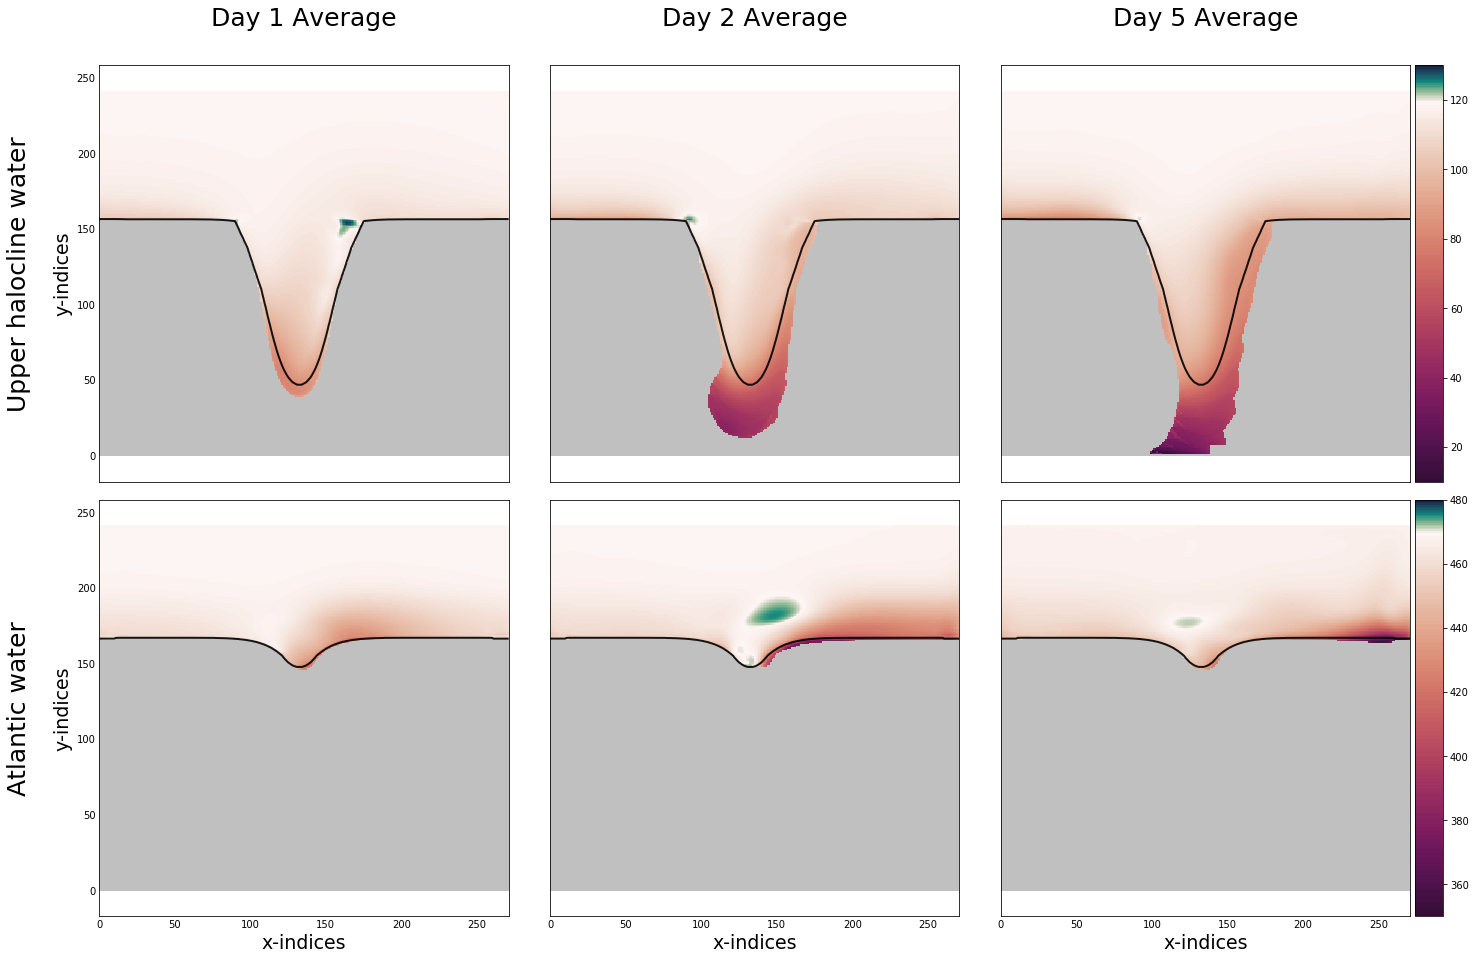

In [9]:
fig = plot(vosaline_daily_all, salt_all, water_mass, ttls, vmaxs, vmins, bathy)
fig.savefig('./surface_watermass_depths_ideal.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())

# Realistic

In [10]:
kind = 'real'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

bathy0 = nc.Dataset('/ocean/imachuca/Canyons/results_mackenzie/extended_domain/real_base/1_real_bathy_for_agrif_fix.nc')['Bathymetry'][:]
bathy = bathy0[1:-1, 1:-1]

In [11]:
vosaline_daily1, tmask1, deptht = get_salt_daily(time_s_day1)
vosaline_daily2, tmask2, deptht = get_salt_daily(time_s_day2)
vosaline_daily5, tmask5, deptht = get_salt_daily(time_s_day5)

In [12]:
vosaline_daily_all = [vosaline_daily1, vosaline_daily2, vosaline_daily5]
vmaxs = [130, 480]
vmins = [10, 350]

0 0 119.43728677712046 77.31133813951212 122.76160831977163
0 1 469.7139659322341 380.2907779434269 483.0826185935765
1 0 119.43728677712046 38.880873346036296 119.35464595557437
1 1 469.7139659322341 296.9941018707248 508.63300546776094
2 0 119.43728677712046 56.064784281304675 119.23905471043977
2 1 469.7139659322341 302.1429176251868 476.9478705825851


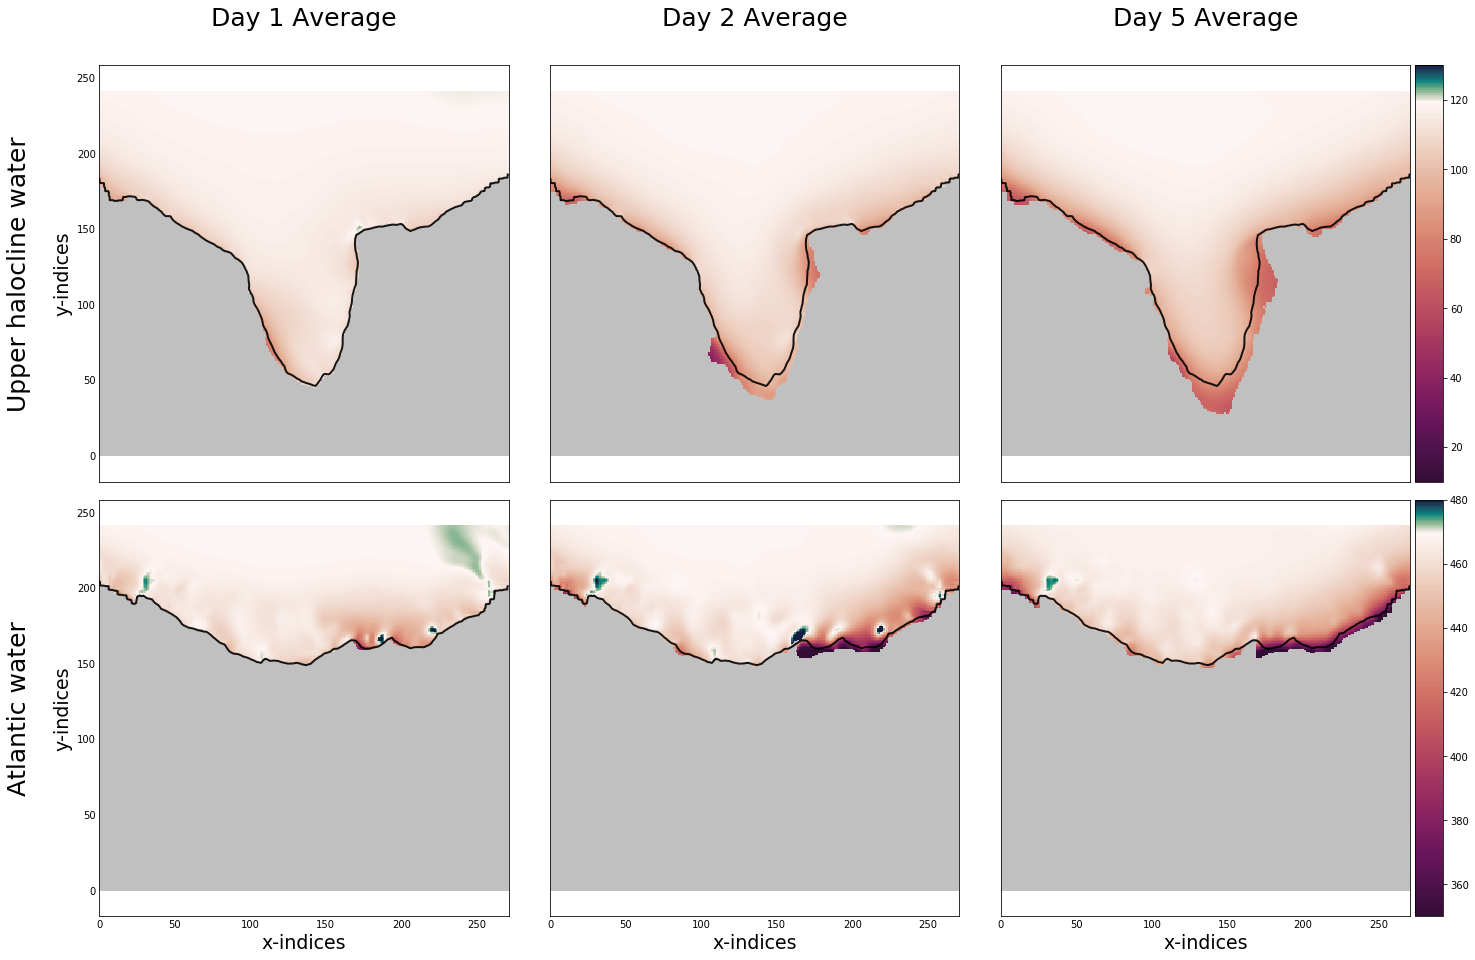

In [13]:
fig = plot(vosaline_daily_all, salt_all, water_mass, ttls, vmaxs, vmins, bathy)
fig.savefig('./surface_watermass_depths_real.png', dpi=200, bbox_inches='tight', format='png', facecolor=fig.get_facecolor())